# Simulação de Monte Carlo
(Incompleto)

A **Simulação de Monte Carlo** é um método estatístico amplamente utilizado para estimar valores ainda não conhecidos, principalmente na física e em algumas áreas da engenharia. O método se baseia em calcular um grande número de simulações de uma probabilidade que estima a chance de corrência de algum evento ainda a ser observado, em outras palavras, é uma forma de simular o comportamento de um evento futuro com base nas probabilidades já conhecidas e testadas pelo próprio método.

Utilizando a **Lei dos Grandes Números**, é possível estimar com um relativo grau de confiança elevado (a depender do caso e dos dados obtidos previamente) que os resultados irão tender a uma determinada distribuição seguindo as probabilidades estabelecidas. Existem ainda 3 tipos diferentes de algoritmos de Monte Carlo:
- Erro-Unilateral
- Erro-Bilateral
- Erro-Não-Limitado

A diferença entre os tipos é quanto a precisão de suas respostas com base no cálculo de erros eperados, sendo que para cada caso o erro estimado é tratado de forma diferente.

A utilização do Método de Monte Carlo no **Mercado Financeiro** é focado principalmente em questões relacionadas a Gestão de Riscos, principalmente em **_Stress Tests_** e simulações de cenários específicos. Este projeto tem como objetivo aplicar este método em um contexto de **Finanças Quantitativas**, simulando os retornos esperados de um portfólio.

#### As estapas deste projeto são:
1) Obter Dados e calcular os retornos do portfólio
2) Criar séries temporáis sintéticas
3) Monte Carlo
4) Verificar resultados

In [ ]:
#Instalando Bibliotecas
%pip install pandas --quiet
%pip install numpy --quiet
%pip install matplotlib --quiet


In [2]:
#Importando Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

### 1 - Obter Dados e calcular os retornos do portfólio

In [4]:
#Preços de fechamento de 10 ativos diferentes
df = pd.read_csv(r"C:\Users\User\Desktop\Python e R\Git\Projetos\Finanças\Simulação de Monte Carlo", index_col='datetime', parse_dates=True)
df = df.pivot_table(index='datetime',columns='symbol',values='close')
df.head()

symbol,CPFE3,ELET3,ELET6,HYPE3,LOGN3,RECV3,RRRP3,SLCE3,SMTO3,UNIP6
datetime,,,,,,,,,,
2021-06-01,24.85,44.01,42.87,35.68,19.87,16.18,41.19,44.58,33.05,76.98
2021-06-02,24.84,44.17,43.02,35.11,20.20,16.17,41.40,44.81,33.46,83.64
2021-06-04,25.12,44.77,44.02,34.74,19.92,16.68,41.24,44.45,33.68,84.46
2021-06-07,25.22,45.53,44.41,35.83,19.86,16.31,40.07,43.88,33.52,75.81
2021-06-08,25.02,44.40,43.04,34.70,19.45,16.05,40.01,43.72,33.63,71.48


In [8]:
# definindo o sizing para cada ativo na carteira
## neste caso optei por distribuir os ativos com pesos iguais
pesos = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [7]:
# calculando número de ativos na carteira
num_ativ = len(df.columns)
print(f'Temos {num_ativ} ativos na carteira.')

# calculando seus retornos diários
retorno = df.pct_change().dropna()

retorno.head()

Temos 10 ativos em nossa carteira.


symbol,CPFE3,ELET3,ELET6,HYPE3,LOGN3,RECV3,RRRP3,SLCE3,SMTO3,UNIP6
datetime,,,,,,,,,,
2021-06-02,-0.000402,0.003636,0.003499,-0.015975,0.016608,-0.000618,0.005098,0.005159,0.012405,0.086516
2021-06-04,0.011272,0.013584,0.023245,-0.010538,-0.013861,0.031540,-0.003865,-0.008034,0.006575,0.009804
2021-06-07,0.003981,0.016976,0.008860,0.031376,-0.003012,-0.022182,-0.028371,-0.012823,-0.004751,-0.102415
2021-06-08,-0.007930,-0.024819,-0.030849,-0.031538,-0.020645,-0.015941,-0.001497,-0.003646,0.003282,-0.057116
2021-06-09,-0.021982,-0.000225,0.001162,-0.014409,-0.001542,0.000623,-0.011497,-0.002059,0.062147,0.013151


### 2 - Criar séries temporáis sintéticas

Para calcularmos estas séries temporais precisamos primeiro seguir a seguinte equação: <br>
#### **<center> Retornos = μ_original + Rpdf * L </center>** <br>

Sendo:<br> 
- **μ_original**: a média amostral dos dados originais
- **Rpdf**: uma matriz onde cada coluna é um vetor aleatório que segue alguma distribuição probabilística já conhecida (neste caso iremos utilizar a dist. normal)<br>
- **L**: uma matriz triangular inferior vinda de uma decomposição da matriz de covariância dos dados originais

Ao final, iremos criar uma função com todos os passos, para que este processo possa ser repitido diversas vezes para a simulação. <br>
Ainda assim é necessário realizar os passos separadamente antes, para que possamos testar os resultados em cada etapa!

In [11]:
# calculando matriz de covariância
cov_ret = retorno.cov()
cov_ret

symbol,CPFE3,ELET3,ELET6,HYPE3,LOGN3,RECV3,RRRP3,SLCE3,SMTO3,UNIP6
symbol,,,,,,,,,,
CPFE3,0.000267,0.000174,0.000168,0.000101,0.000035,0.000127,0.000076,0.000045,0.000091,0.000050
ELET3,0.000174,0.000567,0.000504,0.000179,0.000146,0.000262,0.000224,0.000080,0.000174,0.000146
ELET6,0.000168,0.000504,0.000485,0.000155,0.000139,0.000244,0.000206,0.000067,0.000149,0.000154
HYPE3,0.000101,0.000179,0.000155,0.000335,0.000115,0.000175,0.000175,0.000029,0.000104,0.000077
LOGN3,0.000035,0.000146,0.000139,0.000115,0.000924,0.000207,0.000153,0.000092,0.000106,0.000070
RECV3,0.000127,0.000262,0.000244,0.000175,0.000207,0.001153,0.000650,0.000228,0.000261,0.000286
RRRP3,0.000076,0.000224,0.000206,0.000175,0.000153,0.000650,0.001052,0.000263,0.000221,0.000266
SLCE3,0.000045,0.000080,0.000067,0.000029,0.000092,0.000228,0.000263,0.000622,0.000227,0.000093
SMTO3,0.000091,0.000174,0.000149,0.000104,0.000106,0.000261,0.000221,0.000227,0.000467,0.000140


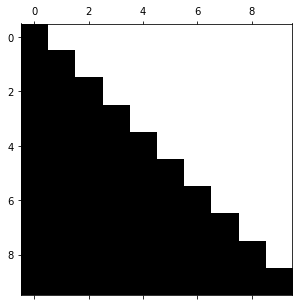

In [14]:
# criando matriz aleatória
num= 300
random_matrix = np.random.normal(size=(num, num_ativ))

# decomposição de Cholesky
L = LA.cholesky(cov_ret)

# verificando se a matriz é realmente triangular inferiror
plt.figure(figsize=(5,5))
plt.spy(L)
plt.show()

In [15]:
# calcular média amostral original
shape = [num, num_ativ]
med_original = retorno.mean()[None,:] * np.ones(shape=shape)

# aplicando as variáveis geradas na equação
Retornos = med_original + np.inner(random_matrix,L)
Retornos = pd.DataFrame(Retornos, columns=df.columns)
Retornos

C:\Users\Bluestone\AppData\Local\Temp\ipykernel_13264\3965517272.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  med_original = retorno.mean()[None,:] * np.ones(shape=shape)


symbol,CPFE3,ELET3,ELET6,HYPE3,LOGN3,RECV3,RRRP3,SLCE3,SMTO3,UNIP6
0,0.030564,-0.003796,0.012271,-0.012927,-0.028070,0.001417,-0.023983,0.022986,0.000950,0.020868
1,-0.001864,-0.002606,-0.003628,-0.004968,-0.017070,0.044593,0.048123,0.010525,-0.009034,-0.000257
2,-0.012694,0.019730,0.024054,-0.008744,0.008389,0.037187,0.037787,0.001666,0.013955,0.053895
3,-0.017493,0.015909,0.009708,0.002426,-0.027729,0.110460,0.087906,0.043587,0.025899,0.022705
4,0.009816,-0.005456,0.000704,-0.004600,0.004147,0.001149,-0.015174,0.023499,-0.004702,-0.018342
...,...,...,...,...,...,...,...,...,...,...
295,0.005057,0.023359,0.018762,-0.021224,-0.040782,0.006821,0.001856,0.002399,0.009015,0.006765
296,0.001488,-0.016926,-0.017329,-0.025959,-0.031385,-0.036442,0.039622,0.026391,0.012223,0.040469
297,-0.006400,-0.007229,-0.001251,-0.030620,-0.002320,-0.013121,0.055125,-0.021209,-0.017594,0.026080
298,0.025328,0.029939,0.034200,0.042133,-0.016778,0.042301,0.023259,0.052159,0.048177,0.018661


In [18]:
# definindo a função monte_carlo
def monte_carlo(N, num, data, pesos, aporte):
    med_original = retorno.mean()[None,:] * np.ones([num, len(data.columns)])
    port_ret = np.zeros([num, N])
    L = LA.cholesky(data.cov())
    size = (num, len(pesos))
    
    for i in range(N):
        random_matrix = np.random.normal(size=size)
        Retornos = med_original + np.inner(random_matrix, L)
        port_ret[:,i] = np.cumprod(np.inner(pesos, Retornos) + 1) * aporte
        
    return port_ret, Retornos

### 3 - Monte Carlo

Aplicar função criada e plotar gráfico referente às simulações

C:\Users\Bluestone\AppData\Local\Temp\ipykernel_13264\4174088825.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  med_original = retorno.mean()[None,:] * np.ones([num, len(data.columns)])


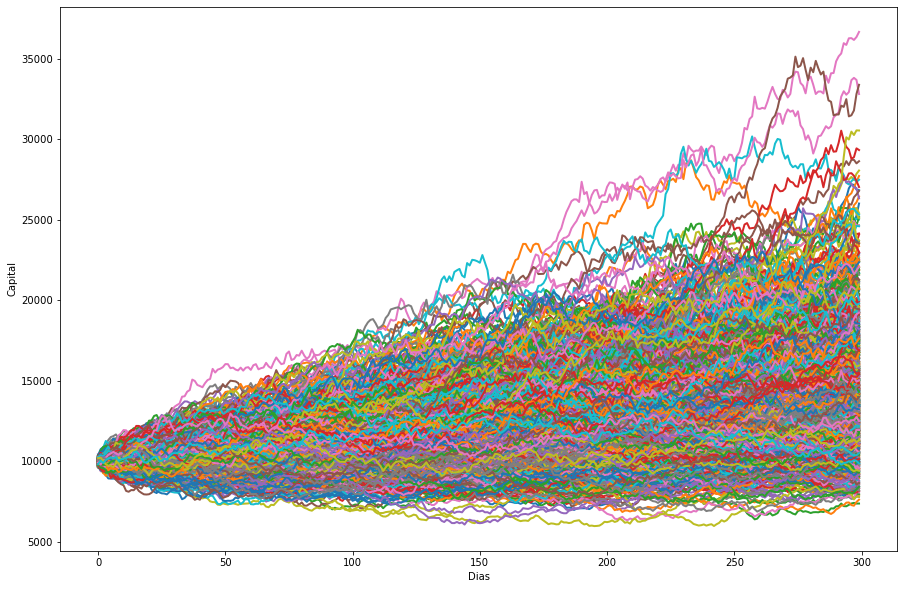

In [26]:
# selecionar parâmetros e usar função
num = 300
N = 1000
aporte = 10000

port_ret, Retornos = monte_carlo(N, num, retorno, pesos, aporte)

# plotar simulação
plt.figure(figsize=(15, 10))
plt.plot(port_ret, linewidth=2)
plt.ylabel('Capital')
plt.xlabel('Dias')
plt.show()

### 4 - Verificar resultados